#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/nic.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
997,27/07/2022,1.070,1.0700,1.0350,1.055,1.055,8207216,1.35,2.5,125.0
998,28/07/2022,1.075,1.0875,1.0400,1.085,1.085,9352717,1.35,2.5,125.0
999,29/07/2022,1.100,1.1050,1.0850,1.085,1.085,24219681,1.35,2.5,125.0
1000,1/08/2022,1.100,1.1050,1.0575,1.070,1.070,12402984,1.35,2.5,125.0
1001,2/08/2022,1.060,1.0750,1.0350,1.055,1.055,11196804,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.nic.drop()

# #Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.nic.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nic.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.nic.delete_one(
    {'Date': last_date}
)

DELETE: 29/08/2022 1.0149999856948853


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nic.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)


NEW LAST VALUE IN MONGODB: 26/08/2022 1.0449999570846558
Last date in MongoDb: 26-08-2022. Today's date: 30-08-2022


UPDATE MONGO DB

In [6]:
# #Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'NIC.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,1.025,0.985,1.00,1.015,10208444,1.015
2022-08-30,1.030,1.010,1.02,1.025,8134730,1.025


In [7]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']

stock_quote


,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,1.025,0.985,1.00,1.015,10208444,1.015,1.85,2.5,125
1,30/08/2022,1.030,1.010,1.02,1.025,8134730,1.025,1.85,2.5,125


In [8]:
records=stock_quote.to_dict('records')
print(records)

[{'Date': '29/08/2022', 'High': 1.024999976158142, 'Low': 0.9850000143051147, 'Open': 1.0, 'Close': 1.0149999856948853, 'Volume': 10208444, 'Adj Close': 1.0149999856948853, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}, {'Date': '30/08/2022', 'High': 1.0299999713897705, 'Low': 1.0099999904632568, 'Open': 1.0199999809265137, 'Close': 1.024999976158142, 'Volume': 8134730, 'Adj Close': 1.024999976158142, 'RBA': 1.85, 'FED': 2.5, 'CPI': 125}]


In [9]:
#INSERT NEW DATA INTO MONGODB
db.nic.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.nic.find()))
last_vals = df_mongo.iloc[-10:].values
last_vals

array([[ObjectId('62ff441f7aa80907b626cdc8'), '17/08/2022',
        1.1349999904632568, 1.1749999523162842, 1.1325000524520874,
        1.149999976158142, 1.149999976158142, 7297758, 1.85, 2.5, 125.0],
       [ObjectId('630496fb90aae08aeda3fddd'), '18/08/2022',
        1.149999976158142, 1.1549999713897705, 1.1200000047683716, 1.125,
        1.125, 5871704, 1.85, 2.5, 125.0],
       [ObjectId('630496fb90aae08aeda3fdde'), '19/08/2022', 1.125,
        1.1449999809265137, 1.0750000476837158, 1.090000033378601,
        1.090000033378601, 11355442, 1.85, 2.5, 125.0],
       [ObjectId('630496fb90aae08aeda3fddf'), '22/08/2022',
        1.0700000524520874, 1.0850000381469727, 1.0525000095367432,
        1.059999942779541, 1.059999942779541, 8914854, 1.85, 2.5, 125.0],
       [ObjectId('630746c1e6c48c7826d598b9'), '23/08/2022',
        1.059999942779541, 1.090000033378601, 1.0449999570846558,
        1.0549999475479126, 1.0549999475479126, 7178490, 1.85, 2.5,
        125.0],
       [ObjectId('6

In [10]:
import pandas as pd
df_mongo = pd.DataFrame(list(db.nic.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_close,last_date)

1.024999976158142 30/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [11]:
df_mongo = pd.DataFrame(list(db.nic.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(1022, 1)

In [12]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [13]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(818, 1)

In [14]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.03859649, 0.02105263, 0.04561404, 0.05263158, 0.05614035,
       0.07017544, 0.0877193 , 0.0877193 , 0.09473684, 0.09473684,
       0.08070175, 0.07719298, 0.07017544, 0.05964912, 0.05614035,
       0.05614035, 0.05263158, 0.04561404, 0.05964912, 0.05614035,
       0.05964912, 0.05964912, 0.05964912, 0.06315789, 0.06315789,
       0.05614035, 0.05614035, 0.05964912, 0.05263158, 0.07017544,
       0.05964912, 0.05263158, 0.05263158, 0.05964912, 0.05263158,
       0.05263158, 0.05263158, 0.05964912, 0.04561404, 0.04912281,
       0.04561404, 0.04561404, 0.04912281, 0.04561404, 0.04561404,
       0.04561404, 0.03859649, 0.03157895, 0.03508772, 0.03508772,
       0.03157895, 0.02807018, 0.03508772, 0.03157895, 0.03508772,
       0.03508772, 0.04561404, 0.04210526, 0.04210526, 0.03859649])]
[0.04210526315789473]


# Prepare train data for LSTM model

In [15]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(758, 60)

In [16]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(758, 60, 1)

# Build the LSTM model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

758/758 [==============================] - 17s 19ms/step - loss: 0.0032


In [20]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [21]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [22]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [23]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

3.8880121474179694e-05

C:\Users\antoi\AppData\Local\Temp/ipykernel_12680/1379553529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


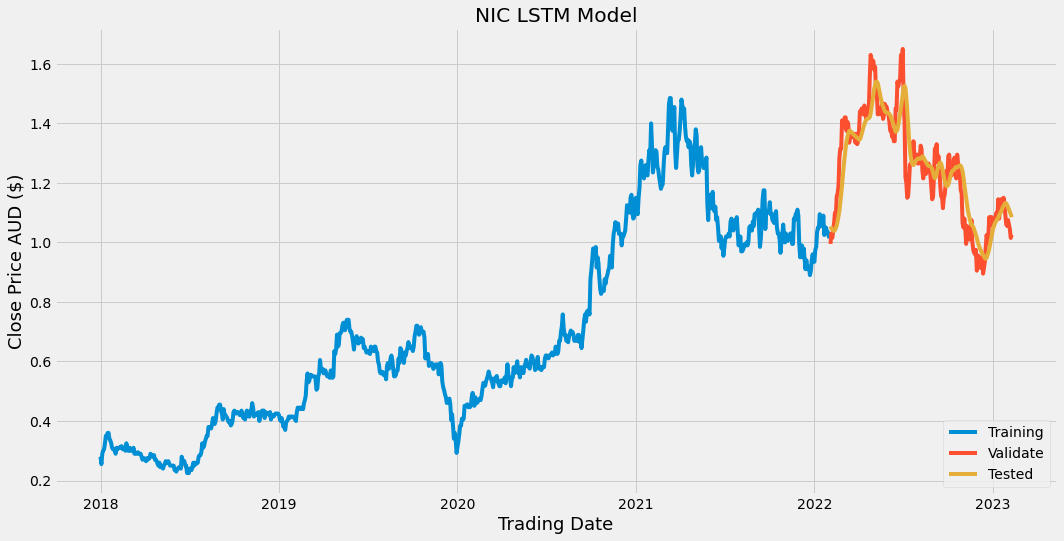

In [24]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NIC LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
plt.xticks([0,200,400,600,800,1000],[2018,2019,2020,2021,2022,2023])
plt.savefig('../static/data/images/nic_graph.png')
plt.show()

# Test data Predictions on the Model

In [25]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_12680/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of       Close  Predictions  Difference
818   0.995     1.053731   -0.058731
819   1.030     1.047252   -0.017252
820   1.015     1.043332   -0.028332
821   1.035     1.039793   -0.004793
822   1.065     1.038532    0.026468
...     ...          ...         ...
1017  1.075     1.117596   -0.042596
1018  1.060     1.110408   -0.050408
1019  1.045     1.103012   -0.058012
1020  1.015     1.094939   -0.079939
1021  1.025     1.084703   -0.059703

[204 rows x 3 columns]>

In [26]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.nic.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [27]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [28]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $1.024999976158142 Predicted next day share price $1.06


# Save the Model

In [29]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nic_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list nic_sixty and load df

#PREDICT USING LOADED MODEL

In [30]:
from keras.models import load_model
model_in = load_model('../static/nic_model.sav')

In [31]:
# query the nic collection and load into dataframe

df_mongo = pd.DataFrame(list(db.nic.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[1.2375    ],
       [1.215     ],
       [1.175     ],
       [1.13      ],
       [1.035     ],
       [1.045     ],
       [1.07      ],
       [1.0275    ],
       [0.98      ],
       [1.005     ],
       [1.04      ],
       [1.        ],
       [0.9975    ],
       [1.03      ],
       [1.035     ],
       [1.        ],
       [0.975     ],
       [0.96      ],
       [0.955     ],
       [0.96      ],
       [0.905     ],
       [0.91      ],
       [0.9475    ],
       [0.935     ],
       [0.915     ],
       [0.905     ],
       [0.915     ],
       [0.89      ],
       [0.9025    ],
       [0.925     ],
       [0.9525    ],
       [1.        ],
       [1.        ],
       [1.01      ],
       [1.035     ],
       [1.035     ],
       [1.04      ],
       [1.085     ],
       [1.0575    ],
       [1.03499997],
       [1.03499997],
       [1.06500006],
       [1.06500006],
       [1.05250001],
       [1.08500004],
       [1.08000004],
       [1.10500002],
       [1.125

In [32]:
# workings for scatterplot
# df_mongo_nic = pd.DataFrame(list(db.nic.find()))
# df_nic = df_mongo_nic.iloc[-4250:]
# nic_dict = df_nic.to_dict(orient='records')
# #print(nic_dict)

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/nic_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_nic(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_nic(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[1.05,
 1.05,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.04,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,
 1.05,

In [34]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df


,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_12680/735098504.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


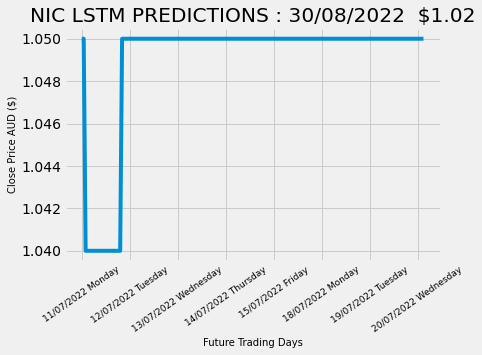

In [35]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,1]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,1]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,1]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,1]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,1]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,1]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,1]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,1]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('NIC LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/nic_pred.png', bbox_inches="tight")
plt.show()

In [36]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.04},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price': 1.05},
 {'Price':

In [37]:
# df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

818 1022 1182


,Close
1171,1.05
1172,1.05
1173,1.05
1174,1.05
1175,1.05
1176,1.05
1177,1.05
1178,1.05
1179,1.05
1180,1.05


In [38]:
first_val=df_mongo.iloc[:,1].values
first_date = first_val[0]
print("FIRST DATA VALUE: "+first_date.strip('/02'))

FIRST DATA VALUE: 8/2018


C:\Users\antoi\AppData\Local\Temp/ipykernel_12680/1275011206.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


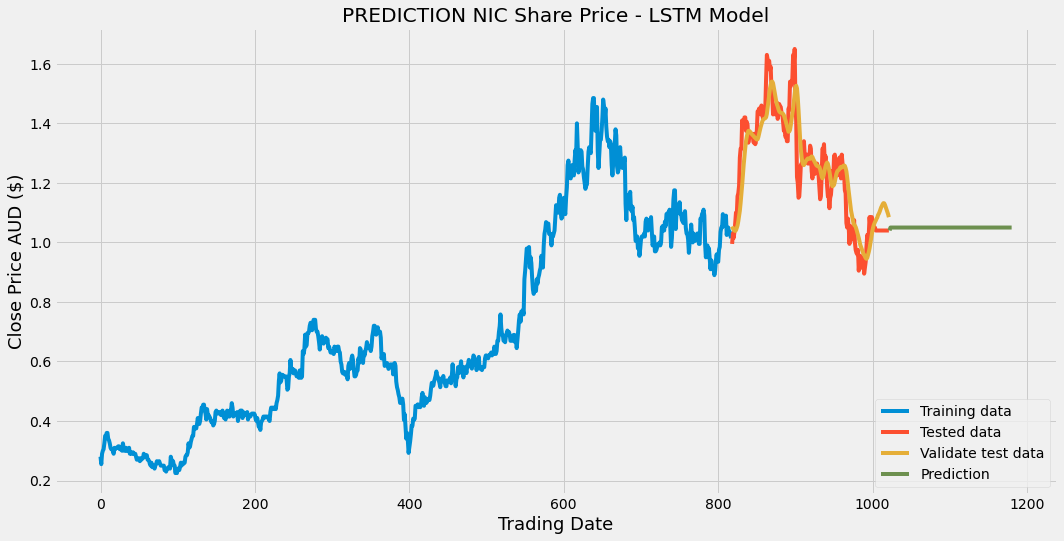

In [39]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION NIC Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
# x = np.arange(2018,2024,1)
# plt.xticks([0,200,400,600,800,1000],x)
plt.savefig('../static/data/images/nic_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [40]:
# Query all
name = 'NIC'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f85c349cd16f126af85ea7'), 'model': 'RFR', 'name': 'NIC', 'date': '12/08/2022', 'predicted': 0.93, 'actual': 1.14, 'difference': -0.21, 'accuracy': 91.96}
{'_id': ObjectId('630c9431a16d0c7f06e32a45'), 'model': 'LSTM', 'name': 'NIC', 'date': '29/08/2022', 'predicted': 1.03, 'actual': 1.01, 'difference': 0.02, 'rmse': 0.0299}


In [41]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f85c349cd16f126af85ea7'), 'model': 'RFR', 'name': 'NIC', 'date': '12/08/2022', 'predicted': 0.93, 'actual': 1.14, 'difference': -0.21, 'accuracy': 91.96}


In [42]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022, predicted $1.06, actual $1.02, difference 0.040000000000000036, rmse 4e-05


In [43]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f85c349cd16f126af85ea7'), 'model': 'RFR', 'name': 'NIC', 'date': '12/08/2022', 'predicted': 0.93, 'actual': 1.14, 'difference': -0.21, 'accuracy': 91.96}
{'_id': ObjectId('630dce6096472ec0af670977'), 'model': 'LSTM', 'name': 'NIC', 'date': '30/08/2022', 'predicted': 1.06, 'actual': 1.02, 'difference': 0.04, 'rmse': 4e-05}


In [44]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'